In [ ]:
# Copyright 2021 NVIDIA CORPORATION
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import glob
import pandas as pd
import numpy as np
import cudf
import cupy
import gc

from datetime import datetime

In [2]:
files = glob.glob('/raid/recsys2021_pre_TE_validXGB/*.parquet')

In [3]:
import os, time
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"

In [4]:
import dask as dask, dask_cudf
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import subprocess

In [5]:
cluster = LocalCUDACluster(local_directory='/raid/dask9450/', device_memory_limit=0.4)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:45519 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 429.50 GB


In [6]:
df = dask_cudf.read_parquet(sorted(files))

In [7]:
quantiles = [240,  588, 1331, 3996]

df['group'] = 0
for i, quant in enumerate(quantiles):
    df['group'] = (df['group']+(df['a_follower_count']>quant).astype('int8')).astype('int8')

In [8]:
fold = 0
train = df[~(df['folds']==fold)]
valid = df[(df['folds']==fold)]
del df

In [9]:
train, valid = dask.persist(train, valid)

In [10]:
print(train.shape[0].compute(), valid.shape[0].compute())

11569644 2892116


In [11]:
label_names = ['reply', 'retweet', 'retweet_comment', 'like']
DONT_USE = ['timestamp','a_account_creation','b_account_creation','engage_time', 'folds',
            'fold','b_user_id','a_user_id', 'a_account_creation', 
            'b_account_creation', 'elapsed_time', 'links','domains','hashtags','id', 'date', 'is_train', 
            'tw_original_http0', 'tw_original_user0', 'tw_original_user1', 'tw_original_user2',
            'tw_rt_count_char', 'tw_rt_count_words', 'tw_rt_user0', 'tw_tweet', 'tw_word0',
            'tw_word1', 'tw_word2', 'tw_word3', 'tw_word4', 'tw_count_hash', 'dt_second']
DONT_USE += label_names
features = [c for c in train.columns if c not in DONT_USE]

RMV = [c for c in DONT_USE if c in train.columns and c not in label_names]
RMV = list(set(RMV))

In [12]:
%%time

train = train.drop(RMV,axis=1)
wait(train)

CPU times: user 32 ms, sys: 3.53 ms, total: 35.6 ms
Wall time: 32.1 ms


DoneAndNotDoneFutures(done={<Future: finished, type: cudf.DataFrame, key: ('getitem-27b45203e8e72ce4c9f432891e21b162', 1)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-27b45203e8e72ce4c9f432891e21b162', 3)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-27b45203e8e72ce4c9f432891e21b162', 2)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-27b45203e8e72ce4c9f432891e21b162', 4)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-27b45203e8e72ce4c9f432891e21b162', 5)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-27b45203e8e72ce4c9f432891e21b162', 6)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-27b45203e8e72ce4c9f432891e21b162', 0)>}, not_done=set())

In [13]:
%%time

valid = valid.drop(RMV,axis=1)
wait(valid)

CPU times: user 32 ms, sys: 3.23 ms, total: 35.2 ms
Wall time: 32.1 ms


DoneAndNotDoneFutures(done={<Future: finished, type: cudf.DataFrame, key: ('getitem-92dd6b4d36b8d32cc68bfc72860683f4', 4)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-92dd6b4d36b8d32cc68bfc72860683f4', 0)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-92dd6b4d36b8d32cc68bfc72860683f4', 2)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-92dd6b4d36b8d32cc68bfc72860683f4', 3)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-92dd6b4d36b8d32cc68bfc72860683f4', 5)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-92dd6b4d36b8d32cc68bfc72860683f4', 6)>, <Future: finished, type: cudf.DataFrame, key: ('getitem-92dd6b4d36b8d32cc68bfc72860683f4', 1)>}, not_done=set())

In [14]:
Y_train = train[label_names]
Y_train, = dask.persist(Y_train)
Y_train.head()    
    
train = train.drop(['tweet_id']+label_names,axis=1)
train, = dask.persist(train)
train.head()


features = [c for c in train.columns if c not in DONT_USE]
print('Using %i features:'%(len(features)),train.shape[1])
np.asarray(features)

Using 179 features: 179


array(['TE_a_user_id_like', 'TE_a_user_id_reply', 'TE_a_user_id_retweet',
       'TE_a_user_id_retweet_comment', 'TE_b_is_verified_tweet_type_like',
       'TE_b_is_verified_tweet_type_reply',
       'TE_b_is_verified_tweet_type_retweet',
       'TE_b_is_verified_tweet_type_retweet_comment',
       'TE_b_user_id_a_user_id_like', 'TE_b_user_id_a_user_id_reply',
       'TE_b_user_id_a_user_id_retweet',
       'TE_b_user_id_a_user_id_retweet_comment', 'TE_b_user_id_like',
       'TE_b_user_id_reply', 'TE_b_user_id_retweet',
       'TE_b_user_id_retweet_comment',
       'TE_b_user_id_tweet_type_language_like',
       'TE_b_user_id_tweet_type_language_reply',
       'TE_b_user_id_tweet_type_language_retweet',
       'TE_b_user_id_tweet_type_language_retweet_comment',
       'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_like',
       'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_reply',
       'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified

In [15]:
Y_valid = valid[label_names]
Y_valid, = dask.persist(Y_valid)
Y_valid.head()    
    
valid = valid.drop(['tweet_id']+label_names,axis=1)
valid, = dask.persist(valid)
valid.head()


features = [c for c in valid.columns if c not in DONT_USE]
print('Using %i features:'%(len(features)),valid.shape[1])
np.asarray(features)

Using 179 features: 179


array(['TE_a_user_id_like', 'TE_a_user_id_reply', 'TE_a_user_id_retweet',
       'TE_a_user_id_retweet_comment', 'TE_b_is_verified_tweet_type_like',
       'TE_b_is_verified_tweet_type_reply',
       'TE_b_is_verified_tweet_type_retweet',
       'TE_b_is_verified_tweet_type_retweet_comment',
       'TE_b_user_id_a_user_id_like', 'TE_b_user_id_a_user_id_reply',
       'TE_b_user_id_a_user_id_retweet',
       'TE_b_user_id_a_user_id_retweet_comment', 'TE_b_user_id_like',
       'TE_b_user_id_reply', 'TE_b_user_id_retweet',
       'TE_b_user_id_retweet_comment',
       'TE_b_user_id_tweet_type_language_like',
       'TE_b_user_id_tweet_type_language_reply',
       'TE_b_user_id_tweet_type_language_retweet',
       'TE_b_user_id_tweet_type_language_retweet_comment',
       'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_like',
       'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_reply',
       'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified

In [16]:
import xgboost as xgb
print('XGB Version',xgb.__version__)

xgb_parms = { 
    'max_depth':8, 
    'learning_rate':0.1, 
    'subsample':0.8,
    'colsample_bytree':0.3, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor' : 'gpu_predictor'
}

XGB Version 1.1.0


In [17]:
for col in train.columns:
    if train[col].dtype=='bool':
        train[col] = train[col].astype('int8')
    if valid[col].dtype=='bool':
        valid[col] = valid[col].astype('int8')
train, = dask.persist(train)
valid, = dask.persist(valid)
train.head()

,TE_a_user_id_like,TE_a_user_id_reply,TE_a_user_id_retweet,TE_a_user_id_retweet_comment,TE_b_is_verified_tweet_type_like,TE_b_is_verified_tweet_type_reply,TE_b_is_verified_tweet_type_retweet,TE_b_is_verified_tweet_type_retweet_comment,TE_b_user_id_a_user_id_like,TE_b_user_id_a_user_id_reply,...,CNN_retweet_comment,CNN_like,BONN_reply,BONN_retweet,BONN_retweet_comment,BONN_like,GXGB_reply,GXGB_retweet,GXGB_retweet_comment,GXGB_like
0,0.558,0.013,0.120,0.005,0.361,0.033,0.055,0.006,0.389,0.025,...,0.003890,0.261384,0.002871,0.086121,0.003869,0.245554,0.000655,0.160317,0.000945,0.342075
1,0.397,0.009,0.087,0.002,0.248,0.006,0.113,0.006,0.397,0.028,...,0.002266,0.180592,0.000274,0.005499,0.000298,0.041783,0.004005,0.015759,0.000780,0.216524
2,0.660,0.014,0.288,0.150,0.248,0.006,0.113,0.006,0.397,0.028,...,0.009646,0.358260,0.015906,0.163109,0.007750,0.502515,0.003504,0.392571,0.017953,0.370824
3,0.397,0.012,0.082,0.003,0.248,0.006,0.113,0.006,0.397,0.028,...,0.007292,0.341846,0.007837,0.124398,0.009337,0.458955,0.003027,0.073922,0.008497,0.372025
4,0.397,0.036,0.040,0.003,0.484,0.040,0.078,0.008,0.397,0.028,...,0.000662,0.315228,0.017967,0.002953,0.000579,0.399552,0.018419,0.007771,0.001450,0.634077


In [18]:
models_index = [0,1,2,3]

In [19]:
def get_colnames(train, name):
    cols = list(train.columns)
    cols = [col for col in cols if 'NN_' not in col and col!='group' and cols!='quantile']
    cols = [x for x in cols if ('TE_' in x and 'a_user_id' in x and name in x) or 'TE_' not in x or ('TE_' in x and 'a_user_id' not in x)]
    cols = cols + [x for x in train.columns if x not in cols and 'TE_switch_' in x]
    cols = cols + [x for x in train.columns if 'BNN_' in x or 'BONN_' in x or 'BOONN_' in x or 'CNN_' in x]
    return(cols)

In [20]:
cols = get_colnames(train, 'like')

In [21]:
!mkdir models_stacked_risk

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: cannot create directory ‘models_stacked_risk’: File exists


In [22]:
import pickle

In [23]:
import time

NROUND = 601
VERBOSE_EVAL = 50
ESR = 50
preds_out = []
best_trees_out = []

for i in models_index:
    name = label_names[i]
    print('#'*25);print('###',name);print('#'*25)
    cols = get_colnames(train, name)
    print(cols)
       
    start = time.time(); print('Creating DMatrix...')
    preds = []
    best_trees = []
    dtrain = xgb.dask.DaskDMatrix(client,data=train[cols].values,label=Y_train.iloc[:, i])
    dvalid = xgb.dask.DaskDMatrix(client,data=valid[cols].values,label=Y_valid.iloc[:, i])
    start = time.time(); print('Training...')
    model = xgb.dask.train(client, xgb_parms, 
                           dtrain=dtrain,
                           evals=[(dvalid,'valid')],
                           num_boost_round=NROUND,
                           early_stopping_rounds=ESR,
                           verbose_eval=VERBOSE_EVAL
                          )
    print('Took %.1f seconds'%(time.time()-start))
    logloss_valid = model["history"]['valid']['logloss'][::VERBOSE_EVAL]
    for ik in range(len(logloss_valid)):
        print(f"{str(VERBOSE_EVAL*ik).zfill(4)} valid-logloss:{logloss_valid[ik]:.5f}")
    for groupid in [0,1,2,3,4]:
        preds.append(xgb.dask.predict(client,model,valid[valid['group']==groupid][cols]))
    start = time.time(); print('Predicting...')
    print('Took %.1f seconds'%(time.time()-start))
    best_trees.append(model['booster'].best_ntree_limit)
    pickle.dump(model, open('./models_stacked_risk/model_' + str(name) + '.pickle', 'wb'))
    preds_out.append(preds)

#########################
### reply
#########################
['TE_a_user_id_reply', 'TE_b_is_verified_tweet_type_like', 'TE_b_is_verified_tweet_type_reply', 'TE_b_is_verified_tweet_type_retweet', 'TE_b_is_verified_tweet_type_retweet_comment', 'TE_b_user_id_a_user_id_reply', 'TE_b_user_id_like', 'TE_b_user_id_reply', 'TE_b_user_id_retweet', 'TE_b_user_id_retweet_comment', 'TE_b_user_id_tweet_type_language_like', 'TE_b_user_id_tweet_type_language_reply', 'TE_b_user_id_tweet_type_language_retweet', 'TE_b_user_id_tweet_type_language_retweet_comment', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_like', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_reply', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_retweet', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_retweet_comment', 'TE_media_tweet_type_language_a_is_verified_b_is_verified_b_follows_a_like', 'TE_media_tweet_type_language_a_is_verified_b_is_verified_b_follows_a_

/opt/conda/envs/rapids/lib/python3.8/site-packages/distributed/worker.py:3451: UserWarning: Large object of size 2.66 MB detected in task graph: 
  [<function predict.<locals>.mapped_predict at 0x7f ... titions>, True]
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


Predicting...
Took 0.0 seconds
#########################
### retweet
#########################
['TE_a_user_id_retweet', 'TE_a_user_id_retweet_comment', 'TE_b_is_verified_tweet_type_like', 'TE_b_is_verified_tweet_type_reply', 'TE_b_is_verified_tweet_type_retweet', 'TE_b_is_verified_tweet_type_retweet_comment', 'TE_b_user_id_a_user_id_retweet', 'TE_b_user_id_a_user_id_retweet_comment', 'TE_b_user_id_like', 'TE_b_user_id_reply', 'TE_b_user_id_retweet', 'TE_b_user_id_retweet_comment', 'TE_b_user_id_tweet_type_language_like', 'TE_b_user_id_tweet_type_language_reply', 'TE_b_user_id_tweet_type_language_retweet', 'TE_b_user_id_tweet_type_language_retweet_comment', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_like', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_reply', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_retweet', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_retweet_comment', 'TE_media_tweet_type_language_a_is_v

Training...
Took 27.2 seconds
0000 valid-logloss:0.60018
0050 valid-logloss:0.02981
0100 valid-logloss:0.02828
0150 valid-logloss:0.02824
Predicting...
Took 0.0 seconds
#########################
### like
#########################
['TE_a_user_id_like', 'TE_b_is_verified_tweet_type_like', 'TE_b_is_verified_tweet_type_reply', 'TE_b_is_verified_tweet_type_retweet', 'TE_b_is_verified_tweet_type_retweet_comment', 'TE_b_user_id_a_user_id_like', 'TE_b_user_id_like', 'TE_b_user_id_reply', 'TE_b_user_id_retweet', 'TE_b_user_id_retweet_comment', 'TE_b_user_id_tweet_type_language_like', 'TE_b_user_id_tweet_type_language_reply', 'TE_b_user_id_tweet_type_language_retweet', 'TE_b_user_id_tweet_type_language_retweet_comment', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_like', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_reply', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified_retweet', 'TE_domains_language_b_follows_a_tweet_type_media_a_is_verified

In [24]:
%%time

import cupy

oof = []
yquantile = []

for i in range(5):
    yquantile.append(valid[valid['group']==i]['group'].values.compute())

yquantile = cupy.concatenate(yquantile)
    
for preds in preds_out:
    oof.append(cupy.concatenate([cupy.array(i.values.compute()) for i in preds]))

oof = cupy.asarray(oof).T

yvalid = []
for i in range(5):
    yvalid.append(Y_valid[valid['group']==i][label_names].values.compute())

yvalid = cupy.concatenate(yvalid)

CPU times: user 3.36 s, sys: 1.55 s, total: 4.91 s
Wall time: 18.7 s


In [25]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

def display_score(rce,ap):
    print('Quantile Group|AP Retweet|RCE Retweet|  AP Reply|  RCE Reply|   AP Like|   RCE Like|AP RT comment|RCE RT comment')
    for i in range(5):
        print(f'{i:9}      ' + \
              ' '.join([f"{ap[engage_type][i]:10.4f}  {rce[engage_type][i]:10.4f}" for engage_type in ['retweet','reply','like','retweet_comment']]))

    print('     Average   ' + ' '.join([f"{np.mean(list(ap[engage_type])):10.4f}  {np.mean(list(rce[engage_type])):10.4f}" for engage_type in ['retweet','reply','like','retweet_comment']]))  
    print(' Sum AP: ' + str(np.sum([np.mean(list(ap[engage_type])) for engage_type in ['retweet','reply','like','retweet_comment']])))
    print(' Sum RCE: ' + str(np.sum([np.mean(list(rce[engage_type])) for engage_type in ['retweet','reply','like','retweet_comment']])))

def precision_recall_curve(y_true,y_pred):
    y_true = y_true.astype('float32')
    ids = cupy.argsort(-y_pred) 
    y_true = y_true[ids]
    y_pred = y_pred[ids]
    y_pred = cupy.flip(y_pred,axis=0)

    acc_one = cupy.cumsum(y_true)
    sum_one = cupy.sum(y_true)
    
    precision = cupy.flip(acc_one/cupy.cumsum(cupy.ones(len(y_true))),axis=0)
    precision[:-1] = precision[1:]
    precision[-1] = 1.

    recall = cupy.flip(acc_one/sum_one,axis=0)
    recall[:-1] = recall[1:]
    recall[-1] = 0
    n = (recall==1).sum()
    
    return precision[n-1:],recall[n-1:],y_pred[n:]

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    recall, prec = cupy.asnumpy(recall), cupy.asnumpy(prec)
    prauc = auc(recall, prec)
    return prauc

def log_loss(y_true,y_pred,eps=1e-15, normalize=True, sample_weight=None):
    y_true = y_true.astype('int32')
    y_pred = cupy.clip(y_pred, eps, 1 - eps)
    if y_pred.ndim == 1:
        y_pred = cupy.expand_dims(y_pred, axis=1)
    if y_pred.shape[1] == 1:
        y_pred = cupy.hstack([1 - y_pred, y_pred])

    y_pred /= cupy.sum(y_pred, axis=1, keepdims=True)
    loss = -cupy.log(y_pred)[cupy.arange(y_pred.shape[0]), y_true]
    return _weighted_sum(loss, sample_weight, normalize).item()

def _weighted_sum(sample_score, sample_weight, normalize):
    if normalize:
        return cupy.average(sample_score, weights=sample_weight)
    elif sample_weight is not None:
        return cupy.dot(sample_score, sample_weight)
    else:
        return sample_score.sum()

# FAST METRIC FROM GIBA
def compute_rce_fast(pred, gt):
    cross_entropy = log_loss(gt, pred)
    yt = np.mean(gt)     
    strawman_cross_entropy = -(yt*np.log(yt) + (1 - yt)*np.log(1 - yt))
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

In [26]:
%%time

txt = ''
rce_output = {}
ap_output = {}
for i, ind in enumerate(models_index):
    prauc_out = []
    rce_out = []
    ap_out = []
    for j in range(5):
        yvalid_tmp = yvalid[yquantile==j][:, i]
        oof_tmp = oof[yquantile==j][:, i]
        prauc = 0
        rce   = compute_rce_fast(oof_tmp, yvalid_tmp).item()
        ap    = average_precision_score(cupy.asnumpy(yvalid_tmp), cupy.asnumpy(oof_tmp))
        prauc_out.append(prauc)
        rce_out.append(rce)
        ap_out.append(ap)
    rce_output[label_names[ind]] = rce_out
    ap_output[label_names[ind]] = ap_out

CPU times: user 9.33 s, sys: 616 ms, total: 9.95 s
Wall time: 10.9 s


In [27]:
%%time
display_score(rce_output, ap_output)

Quantile Group|AP Retweet|RCE Retweet|  AP Reply|  RCE Reply|   AP Like|   RCE Like|AP RT comment|RCE RT comment
        0          0.4624     28.3226     0.2160     23.5180     0.7013     21.1689     0.0761     16.7329
        1          0.4423     27.9110     0.2243     24.2712     0.6869     20.1872     0.0667     16.8392
        2          0.4351     27.7096     0.2528     25.7731     0.6788     20.1130     0.0584     15.2854
        3          0.4341     27.6367     0.2818     27.8809     0.6884     20.8986     0.0623     17.4469
        4          0.4287     29.2842     0.2058     25.1693     0.7465     24.0956     0.0634     18.4973
     Average       0.4405     28.1728     0.2361     25.3225     0.7004     21.2927     0.0654     16.9603
 Sum AP: 1.4424315406185582
 Sum RCE: 91.7482913788698
CPU times: user 1.09 ms, sys: 661 µs, total: 1.75 ms
Wall time: 1.12 ms


In [25]:
((oof[:,1]>0.5)==Y_valid.values[:, 1]).mean()

array(0.92068322)

In [26]:
oof.shape

(1255182, 4)

(array([1.560000e+02, 4.010000e+02, 1.149790e+05, 1.123876e+06,
        1.437200e+04, 1.320000e+03, 1.400000e+01, 1.000000e+00,
        6.200000e+01, 1.000000e+00]),
 array([0.340186  , 0.35373834, 0.36729068, 0.380843  , 0.39439535,
        0.40794766, 0.4215    , 0.43505234, 0.44860467, 0.462157  ,
        0.47570935], dtype=float32),
 <BarContainer object of 10 artists>)

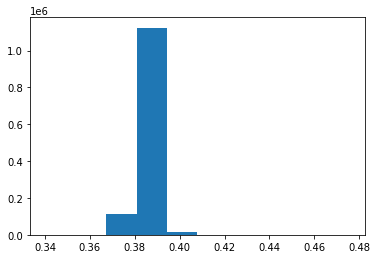

In [27]:
import matplotlib.pyplot as plt

plt.hist(cupy.asnumpy(oof[:,3]))

In [28]:

import cupy 

yvalid = []
for i in range(5):
    yvalid.append(Y_valid[valid['group']==i][label_names].values)
yvalid = cupy.concatenate(yvalid)

yquantile = []
for i in range(5):
    yquantile.append(valid[valid['group']==i]['group'].values)
yquantile = cupy.concatenate(yquantile)

In [29]:
import cupy

oof = []
for preds in preds_out:
    oof.append(cupy.concatenate([cupy.array(i) for i in preds]))

oof = cupy.asarray(oof).T

In [30]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

def display_score(rce,ap):
    print('Quantile Group|AP Retweet|RCE Retweet|  AP Reply|  RCE Reply|   AP Like|   RCE Like|AP RT comment|RCE RT comment')
    for i in range(5):
        print(f'{i:9}      ' + \
              ' '.join([f"{ap[engage_type][i]:10.4f}  {rce[engage_type][i]:10.4f}" for engage_type in ['retweet','reply','like','retweet_comment']]))

    print('     Average   ' + ' '.join([f"{np.mean(list(ap[engage_type])):10.4f}  {np.mean(list(rce[engage_type])):10.4f}" for engage_type in ['retweet','reply','like','retweet_comment']]))  
    print(' Sum AP: ' + str(np.sum([np.mean(list(ap[engage_type])) for engage_type in ['retweet','reply','like','retweet_comment']])))
    print(' Sum RCE: ' + str(np.sum([np.mean(list(rce[engage_type])) for engage_type in ['retweet','reply','like','retweet_comment']])))

def precision_recall_curve(y_true,y_pred):
    y_true = y_true.astype('float32')
    ids = cupy.argsort(-y_pred) 
    y_true = y_true[ids]
    y_pred = y_pred[ids]
    y_pred = cupy.flip(y_pred,axis=0)

    acc_one = cupy.cumsum(y_true)
    sum_one = cupy.sum(y_true)
    
    precision = cupy.flip(acc_one/cupy.cumsum(cupy.ones(len(y_true))),axis=0)
    precision[:-1] = precision[1:]
    precision[-1] = 1.

    recall = cupy.flip(acc_one/sum_one,axis=0)
    recall[:-1] = recall[1:]
    recall[-1] = 0
    n = (recall==1).sum()
    
    return precision[n-1:],recall[n-1:],y_pred[n:]

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    recall, prec = cupy.asnumpy(recall), cupy.asnumpy(prec)
    prauc = auc(recall, prec)
    return prauc

def log_loss(y_true,y_pred,eps=1e-15, normalize=True, sample_weight=None):
    y_true = y_true.astype('int32')
    y_pred = cupy.clip(y_pred, eps, 1 - eps)
    if y_pred.ndim == 1:
        y_pred = cupy.expand_dims(y_pred, axis=1)
    if y_pred.shape[1] == 1:
        y_pred = cupy.hstack([1 - y_pred, y_pred])

    y_pred /= cupy.sum(y_pred, axis=1, keepdims=True)
    loss = -cupy.log(y_pred)[cupy.arange(y_pred.shape[0]), y_true]
    return _weighted_sum(loss, sample_weight, normalize).item()

def _weighted_sum(sample_score, sample_weight, normalize):
    if normalize:
        return cupy.average(sample_score, weights=sample_weight)
    elif sample_weight is not None:
        return cupy.dot(sample_score, sample_weight)
    else:
        return sample_score.sum()

# FAST METRIC FROM GIBA
def compute_rce_fast(pred, gt):
    cross_entropy = log_loss(gt, pred)
    yt = np.mean(gt)     
    strawman_cross_entropy = -(yt*np.log(yt) + (1 - yt)*np.log(1 - yt))
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

In [34]:
txt = ''
rce_output = {}
ap_output = {}
for i, ind in enumerate(models_index):
    prauc_out = []
    rce_out = []
    ap_out = []
    for j in range(5):
        yvalid_tmp = Y_valid.values[:, i]
        oof_tmp = oof[:, i]
        prauc = 0
        rce   = compute_rce_fast(oof_tmp, yvalid_tmp).item()
        ap    = average_precision_score(cupy.asnumpy(yvalid_tmp), cupy.asnumpy(oof_tmp))
        prauc_out.append(prauc)
        rce_out.append(rce)
        ap_out.append(ap)
    rce_output[label_names[ind]] = rce_out
    ap_output[label_names[ind]] = ap_out

In [35]:
%%time
display_score(rce_output, ap_output)

Quantile Group|AP Retweet|RCE Retweet|  AP Reply|  RCE Reply|   AP Like|   RCE Like|AP RT comment|RCE RT comment
        0          0.0797      0.0021     0.0211      0.0022     0.3887      0.0033     0.0056     -0.0023
        1          0.0797      0.0021     0.0211      0.0022     0.3887      0.0033     0.0056     -0.0023
        2          0.0797      0.0021     0.0211      0.0022     0.3887      0.0033     0.0056     -0.0023
        3          0.0797      0.0021     0.0211      0.0022     0.3887      0.0033     0.0056     -0.0023
        4          0.0797      0.0021     0.0211      0.0022     0.3887      0.0033     0.0056     -0.0023
     Average       0.0797      0.0021     0.0211      0.0022     0.3887      0.0033     0.0056     -0.0023
 Sum AP: 0.4951631878928334
 Sum RCE: 0.005266935518521976
CPU times: user 2.44 ms, sys: 0 ns, total: 2.44 ms
Wall time: 1.44 ms


In [33]:
import numpy as np